# Train a CNN classifier on all datasets (binary)

In [1]:
import os
import sys
import numpy as np
import xarray as xr
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
sys.path.append('../')

import core.core_functions as cf
import core.dataset_functions as df
import core.plot_functions as pf
from core.classifiers import deep_classifier

land_masked = True
global_mean = True
dataset_type = 'deseas_historical'
# set to a not-None value to draw the same random samples for repeated calls
random_init = 6546

savename_append = ''

2023-04-04 11:08:47.539275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
ERROR 1: PROJ: proj_create_from_database: Open of /jetfs/home/lbrunner/.conda/envs/model_learning/share/proj failed


## Load and prepare training samples

In [2]:
samples_train_model = cf.get_samples(
    period=slice('1982', '1996'), 
    land_masked=land_masked,
    global_mean=global_mean,
    dataset_type=dataset_type,
    time_steps=200, 
    random_init=random_init, 
    verbose=True, 
    datasets=df.model_names,
)
samples_train_obs = cf.get_samples(
    period=slice('1982', '1996'), 
    land_masked=land_masked,
    global_mean=global_mean,
    dataset_type=dataset_type,
    time_steps=2150,  # 200*43/4
    random_init=random_init, 
    verbose=True,
    datasets=df.observation_names,  # 4 observations
)
samples_train = xr.concat([samples_train_model, samples_train_obs], dim='sample')

samples_valid_model = cf.get_samples(
    period=slice('1997', '2001'), 
    land_masked=land_masked,
    global_mean=global_mean,
    dataset_type=dataset_type,
    time_steps=50, 
    random_init=random_init+1, 
    verbose=True, 
    datasets=df.model_names,
)
samples_valid_obs = cf.get_samples(
    period=slice('1997', '2001'), 
    land_masked=land_masked,
    global_mean=global_mean,
    dataset_type=dataset_type,
    time_steps=537,  # 50*43/4
    random_init=random_init+1, 
    verbose=True,
    datasets=df.observation_names,  # 4 observations
)
samples_valid = xr.concat([samples_valid_model, samples_valid_obs], dim='sample')

Number of datasets: 43
Loaded dataset ACCESS-CM2
Loaded dataset ACCESS-ESM1-5
Loaded dataset AWI-CM-1-1-MR
Loaded dataset AWI-ESM-1-1-LR
Loaded dataset BCC-CSM2-MR
Loaded dataset BCC-ESM1
Loaded dataset CAMS-CSM1-0
Loaded dataset CESM2-WACCM
Loaded dataset CESM2
Loaded dataset CMCC-CM2-HR4
Loaded dataset CMCC-CM2-SR5
Loaded dataset CMCC-ESM2
Loaded dataset CNRM-CM6-1-HR
Loaded dataset CNRM-CM6-1
Loaded dataset CNRM-ESM2-1
Loaded dataset CanESM5
Loaded dataset EC-Earth3-AerChem
Loaded dataset EC-Earth3-Veg-LR
Loaded dataset EC-Earth3-Veg
Loaded dataset EC-Earth3
Loaded dataset FGOALS-f3-L
Loaded dataset FGOALS-g3
Loaded dataset GFDL-CM4
Loaded dataset GFDL-ESM4
Loaded dataset HadGEM3-GC31-LL
Loaded dataset HadGEM3-GC31-MM
Loaded dataset INM-CM4-8
Loaded dataset INM-CM5-0
Loaded dataset IPSL-CM5A2-INCA
Loaded dataset IPSL-CM6A-LR
Loaded dataset KACE-1-0-G
Loaded dataset KIOST-ESM
Loaded dataset MIROC-ES2L
Loaded dataset MIROC6
Loaded dataset MPI-ESM-1-2-HAM
Loaded dataset MPI-ESM1-2-HR
L

In [3]:
X_train = samples_train.transpose('sample', 'lat', 'lon').values
X_valid = samples_valid.transpose('sample', 'lat', 'lon').values
X_train = X_train.reshape(*X_train.shape, 1)  # add a color channel
X_valid = X_valid.reshape(*X_valid.shape, 1) 

y_valid = df.get_category_ids(samples_valid['dataset_name'].values)
y_train = df.get_category_ids(samples_train['dataset_name'].values)

nan_mask = np.any(np.isnan(X_train), axis=0).squeeze()
X_train[:, nan_mask, :] = 0  # set nan to constant value
X_valid[:, nan_mask, :] = 0

print('Number of non-nan features:', (~nan_mask).sum())
print('Number of training samples:', len(y_train))
print('Number of categories:' , len(np.unique(y_train)))

print('Number of samples per dataset:', 
      {dataset: count for dataset, count in zip(*np.unique(samples_train['dataset_name'].values, return_counts=True))})

train_generator = ImageDataGenerator() 
valid_generator = ImageDataGenerator() 
trainset = train_generator.flow(X_train, y_train)
validset = valid_generator.flow(X_valid, y_valid, shuffle=False)

Number of non-nan features: 6888
Number of training samples: 17200
Number of categories: 2
Number of samples per dataset: {'20CR': 2150, 'ACCESS-CM2': 200, 'ACCESS-ESM1-5': 200, 'AWI-CM-1-1-MR': 200, 'AWI-ESM-1-1-LR': 200, 'BCC-CSM2-MR': 200, 'BCC-ESM1': 200, 'CAMS-CSM1-0': 200, 'CESM2': 200, 'CESM2-WACCM': 200, 'CMCC-CM2-HR4': 200, 'CMCC-CM2-SR5': 200, 'CMCC-ESM2': 200, 'CNRM-CM6-1': 200, 'CNRM-CM6-1-HR': 200, 'CNRM-ESM2-1': 200, 'CanESM5': 200, 'EC-Earth3': 200, 'EC-Earth3-AerChem': 200, 'EC-Earth3-Veg': 200, 'EC-Earth3-Veg-LR': 200, 'ERA5': 2150, 'FGOALS-f3-L': 200, 'FGOALS-g3': 200, 'GFDL-CM4': 200, 'GFDL-ESM4': 200, 'HadGEM3-GC31-LL': 200, 'HadGEM3-GC31-MM': 200, 'INM-CM4-8': 200, 'INM-CM5-0': 200, 'IOSST': 2150, 'IPSL-CM5A2-INCA': 200, 'IPSL-CM6A-LR': 200, 'KACE-1-0-G': 200, 'KIOST-ESM': 200, 'MERRA2': 2150, 'MIROC-ES2L': 200, 'MIROC6': 200, 'MPI-ESM-1-2-HAM': 200, 'MPI-ESM1-2-HR': 200, 'MPI-ESM1-2-LR': 200, 'MRI-ESM2-0': 200, 'NESM3': 200, 'NorESM2-LM': 200, 'NorESM2-MM': 200, '

## Set up classifier

In [4]:
classifier = deep_classifier(
    input_shape=X_train.shape[1:], 
    output_shape=len(np.unique(y_train))
)
classifier.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)

history = classifier.fit(
    trainset,
    validation_data=validset,
    epochs=50, 
    callbacks=[early_stopping],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 72, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 18, 128)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 18, 64)         73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 9, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 4, 64)         0

2023-04-04 11:16:38.181603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
538/538 [==============================] - 213s 390ms/step - loss: 0.4175 - acc: 0.7922 - val_loss: 0.3689 - val_acc: 0.8485
Epoch 2/50
538/538 [==============================] - 220s 410ms/step - loss: 0.1311 - acc: 0.9477 - val_loss: 0.2098 - val_acc: 0.9155
Epoch 3/50
538/538 [==============================] - 220s 408ms/step - loss: 0.0716 - acc: 0.9726 - val_loss: 0.2454 - val_acc: 0.9130
Epoch 4/50
538/538 [==============================] - 219s 408ms/step - loss: 0.0435 - acc: 0.9843 - val_loss: 0.4966 - val_acc: 0.8744
Epoch 5/50
538/538 [==============================] - 219s 407ms/step - loss: 0.0427 - acc: 0.9839 - val_loss: 0.1862 - val_acc: 0.9390
Epoch 6/50
538/538 [==============================] - 219s 406ms/step - loss: 0.0463 - acc: 0.9823 - val_loss: 0.2066 - val_acc: 0.9356
Epoch 7/50
538/538 [==============================] - 227s 423ms/step - loss: 0.0295 - acc: 0.9884 - val_loss: 0.2137 - val_acc: 0.9358
Epoch 8/50
538/538 [============================

## Save trained classifier

In [5]:
savename =  'binary_cnn_{}{}{}.h5'.format(
    dataset_type,
    ('_lm' if land_masked else '') + ('_gm' if global_mean else ''),
    savename_append
)

classifier.save(os.path.join('../../data/trained_classifiers', savename))

## Reliability diagram

135/135 [==============================] - 13s 92ms/step


<AxesSubplot: xlabel='Confidence', ylabel='Accuracy'>

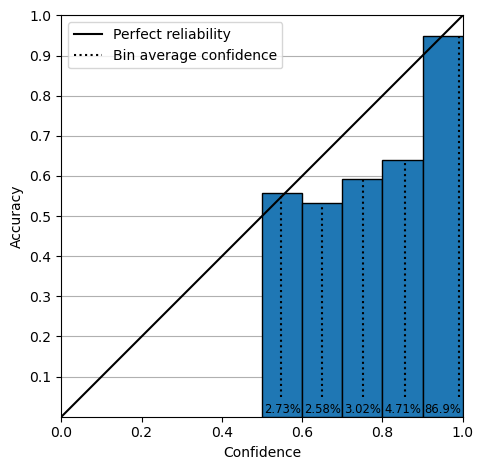

In [6]:
pf.plot_reliability_diagram(classifier, validset)